# Speech Emotion Recognition

+ Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. 

### Import the necessary libraries

In [1]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import speech_recognition as sr
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

### extract_feature ()

#####  to extract the mfcc, chroma, and mel features from a sound file. This function takes 4 parameters- the file name and three Boolean parameters for the three features:

+ mfcc: Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
+ chroma: Pertains to the 12 different pitch classes
+ mel: Mel Spectrogram Frequency

In [2]:
#  Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

### a dictionary named emotions:
+ to hold numbers and the emotions available in the RAVDESS dataset, and a list to hold those we want- calm, happy, fearful, disgust.

In [3]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

# Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust','angry','sad']

#### load the data with a function load_data() 
+ this takes in the relative size of the test set as parameter.
+ x and y are empty lists; we’ll use the glob() function from the glob module to get all the pathnames for the sound files in our dataset. 
+ The pattern we use for this is: “D:\\DOWNLOAD DATA\\speech-emotion-recognition-ravdess-data\\Actor_*\\*.wav”. This is because our dataset looks like this:

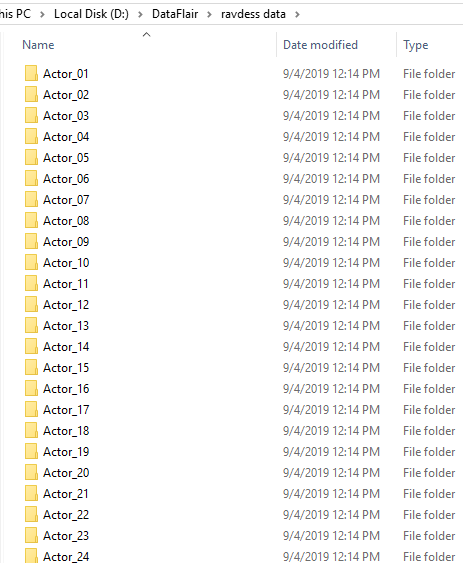

In [4]:
# Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("D:\\DOWNLOAD DATA\\speech-emotion-recognition-ravdess-data\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size,random_state=9)

### Split the dataset into train and test data

In [5]:
# Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

### Observe the shape of the training and testing datasets:

In [6]:
# Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(864, 288)


### get the number of features extracted.

In [7]:
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


### Initialize an MLPClassifier. 
+ This is a Multi-layer Perceptron Classifier; it optimizes the log-loss function using LBFGS or stochastic gradient descent. 
+ Unlike SVM or Naive Bayes, the MLPClassifier has an internal neural network for the purpose of classification. This is a feedforward ANN model.

In [8]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

###  Fit/train the model.

In [9]:
# Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

#### predict the values for the test set. 
+ This gives us y_pred (the predicted emotions for the features in the test set).

In [10]:
# Predict for the test set
y_pred=model.predict(x_test)

### calculate the accuracy of our model

In [11]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 55.90%


### recognize_user_emotion()

+ This function takes user audio as input then recognize its emotion by saving audio.

In [15]:
# Function to record and classify user's audio emotion
def recognize_user_emotion():
    recognizer = sr.Recognizer()
    
    with sr.Microphone() as source:
        print("Please speak something...")
        try:
            audio = recognizer.listen(source, timeout=10)  # Capture audio for up to 5 seconds
            print("Audio recorded. Recognizing emotion...")
            
            with open("rec-1.wav", "wb") as f:
                f.write(audio.get_wav_data())
            
            # Preprocess the user's audio from the temporary file
            user_feature = extract_feature("rec-1.wav", mfcc=True, chroma=True, mel=True)
            
            # Predict emotion
            user_emotion = model.predict([user_feature])[0]
            print(f"Predicted emotion: {user_emotion}")
             
        except sr.WaitTimeoutError:
            print("No audio detected within the timeout period.")
        except Exception as e:
            print(f"An error occurred: {str(e)}")


 + Invoke the recognize_user_emotion()

In [16]:
recognize_user_emotion()

Please speak something...
Audio recorded. Recognizing emotion...
Predicted emotion: happy


In [17]:
recognize_user_emotion()

Please speak something...
Audio recorded. Recognizing emotion...
Predicted emotion: calm


In [18]:
recognize_user_emotion()

Please speak something...
Audio recorded. Recognizing emotion...
Predicted emotion: angry


### predict_emotion_from_audio(audio_file_path)

+ This function will predict the emotion by using audio file saved in your system.

In [25]:
# Function to predict emotion from an audio file
def predict_emotion_from_audio(audio_file_path):
    try:
        # Load the audio file and extract features
        feature = extract_feature(audio_file_path, mfcc=True, chroma=True, mel=True)
        # Predict emotion
        emotion = model.predict([feature])[0]
        return emotion
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

# Example usage:
audio_file_path= r"D:\DOWNLOAD DATA\speech-emotion-recognition-ravdess-data\Actor_06\03-01-06-02-01-02-06.wav"
# audio_file_path= r"D:\DOWNLOAD DATA\speech-emotion-recognition-ravdess-data\Actor_10\03-01-02-02-02-01-10.wav"
# audio_file_path=r"C:\Users\Priya\Desktop\Internship\rec-1.wav"
predicted_emotion = predict_emotion_from_audio(audio_file_path)
if predicted_emotion is not None:
    print(f"Predicted emotion : {predicted_emotion}")
else:
    print("Emotion prediction failed.")

Predicted emotion : fearful
